In [2]:
# Load libraries

# Analysis
import datetime
import glob
import os
import warnings
from datetime import date, timedelta

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
import matplotlib.colors as colors
# Plotting utils 
import matplotlib.pyplot as plt
import numpy as np
import math 
import pandas as pd
import xarray as xr
from cartopy.util import add_cyclic_point
import seaborn as sns

warnings.filterwarnings('ignore')

## Read in instantaneous data from a global run 
Note - this section should change from run to run 

In [3]:
# run_name = "F2010climo.ne30pg3_ne30pg3_mg17.TestGustGlobal_Control_58L.MoveWriteHist_useCOARE_branch.002"
# dir_in   = "/glade/scratch/mdfowler/archive/"+run_name+"/atm/hist/"
# file_ofrac = "/glade/work/mdfowler/gust_cam7/output/F2010climo.ne30pg3_ne30pg3_mg17.TestGustGlobal_Control_58L.MoveWriteHist_useCOARE.001.cam.h0.0002-01.nc"

run_name = "F2010climo.f09_f09_mg17.TestGustGlobal_Control_58L.useCOARE.instOutput.01"
dir_in   = "/glade/scratch/mdfowler/archive/"+run_name+"/atm/hist/"
file_ofrac = "/glade/work/mdfowler/gust_cam7/output/F2010climo.f09_f09_mg17.TestGustGlobal_Control.001.cam.h0.0002-01.nc"

# run_name = "F2010climo.f09_f09_mg17.TestGustGlobal_Control_58Lcam6_branch.003"
# dir_in   = "/glade/scratch/mdfowler/archive/"+run_name+"/atm/hist/"
# file_ofrac = "/glade/work/mdfowler/gust_cam7/output/F2010climo.f09_f09_mg17.TestGustGlobal_Control.001.cam.h0.0002-01.nc"

# ds       = xr.open_dataset(dir_in+run_name+".cam.h1.0004-01-01-10800.nc", decode_times=True) 

ds       = xr.open_dataset(dir_in+run_name+".cam.h1.0001-01-01-00000.nc", decode_times=True) 


startTime = 16    ## Discard the first two days 
nTimes    = len(ds.time.values)-1

print('Start time (raw) : ',ds.time.values[0]) 
print('End time (raw)   : ',ds.time.values[nTimes]) 

ds = ds.isel(time=np.arange(startTime,nTimes,1))

lat = ds.lat.values
lon = ds.lon.values
time = ds.time.values 

nlats = len(lat)
nlons = len(lon)
ntime = len(time)


Start time (raw) :  0001-01-01 00:00:00
End time (raw)   :  0001-01-15 00:00:00


In [4]:
ds_ofrac   = xr.open_dataset(file_ofrac, decode_times=True) 
ofrac      = ds_ofrac.OCNFRAC.values[0,:,:] 

ocnmask     = np.full([nlats,nlons],np.nan)
ocnmask[ofrac>0.1] = 1

In [5]:
zbot = 22.0
pbot = 997.528

## Recreate the shr_flux_mod (COARE) code

In [6]:
def psiuo(zet):
    ## First compute default value of psiuo (zet<0) 
    
    # Dyer & Hicks (1974) for weak instability
    x=(1.0-15.0*zet)**0.25                   # 15 instead of 16
    psik=2.0*np.log((1.0+x)/2.0)+np.log((1.0+x*x)/2.0)-2.0*np.arctan(x)+2.0*np.arctan(1.0)

    # Fairall et al. (1996) for strong instability (Eq.(13))
    x=(1.0-10.15*zet)**0.3333
    psic= 1.5*np.log((1.0+x+x*x)/3.0)-np.sqrt(3.0)*np.arctan((1.0+2.0*x)/np.sqrt(3.0)) +4.0*np.arctan(1.0)/np.sqrt(3.0)
    f=zet*zet/(1.0+zet*zet)
    psiuo_val=(1.0-f)*psik+f*psic

    
    ## Now handle the case when zt .gt. 0
    iGt = np.where(zet>0.0) 
    c   = 0.35*zet 
    c[c>50.0] = 50.0
    psiuo_val[iGt[0][:], iGt[1][:], iGt[2][:]] = -((1.0+1.0*zet[iGt[0][:], iGt[1][:], iGt[2][:]])**1.0+0.667*(zet[iGt[0][:], iGt[1][:], iGt[2][:]]-14.28)/np.exp(c[iGt[0][:], iGt[1][:], iGt[2][:]])+8.525)
    
    return psiuo_val

In [7]:
def psit_30(zet):
    ## First compute default value of psit_30 (zet<0) 
    
    # Dyer & Hicks (1974) for weak instability
    x=(1.0-15.0*zet)**0.5                   # 15 instead of 16
    psik=2.0*np.log((1.0+x)/2.0)

    #Fairall et al. (1996) for strong instability
    x=(1.0-(34.15*zet))**0.3333
    psic= 1.5*np.log((1.0+x+x*x)/3.0)-np.sqrt(3.0)*np.arctan((1.0+2.0*x)/np.sqrt(3.0)) +4.0*np.arctan(1.0)/np.sqrt(3.0)
    f=zet*zet/(1.0+zet*zet)
    psit_30val=(1.0-f)*psik+f*psic

    ## Now handle the case when zet .gt. 0 
    iGt = np.where(zet>0.0) 
    c   = 0.35*zet 
    c[c>50.0] = 50.0
    psit_30val[iGt[0][:], iGt[1][:], iGt[2][:]] = -((1.0+2.0/3.0*zet[iGt[0][:], iGt[1][:], iGt[2][:]])**1.5+0.667*(zet[iGt[0][:], iGt[1][:], iGt[2][:]]-14.28)/np.exp(c[iGt[0][:], iGt[1][:], iGt[2][:]])+8.525)
    
    return psit_30val

In [8]:
## Define constants 
SHR_CONST_RDAIR   = (6.02214e26*1.38065e-23)/28.966
SHR_CONST_RWV     = (6.02214e26*1.38065e-23)/18.016

loc_zvir   = (SHR_CONST_RWV/SHR_CONST_RDAIR)-1.0
loc_karman = 0.4
loc_cpvir  = 1.81e3/1.00464e3
loc_cpdair = 1.00464e3

loc_g = 9.80616
loc_latvap = 2.501e6 # LH f evap.
loc_stebol = 5.67e-8 # SB constant.

zref = 10.0 # Ref height for U
ztref = 2.0 # Ref height for T

zru = zref
zrq = ztref
zrt = ztref

# Renaming a few constants to match COARE (ease of use)
Beta = 1.2
von  = loc_karman
pi   = 3.141593
grav = loc_g
Rgas = 6.02214e26*1.38065e-23
cpa  = loc_cpdair
zi   = 700.0

umin = 0.5 # Floor for vmag.
ocn_frac_lim = 0.01 # Ofrac has to be greater than this for calcs.
    

In [9]:
## Get individual variables 
ts    = ds.TS.values
tbot  = ds.TBOT.values
ubot  = ds.UBOT.values
vbot  = ds.VBOT.values
qbot  = ds.QBOT.values
thbot = ds.THBOT.values
rbot  = ds.RBOT.values 

## Lowest level wind maginitude 
vmag = np.sqrt(ubot**2 + vbot**2) 
vmag[vmag<umin] = umin 

zu = zbot
zt = zbot
zq = zbot 
ua = ubot
va = vbot
ta = tbot
Q  = qbot 


In [10]:
# ## Add in cold air outbreak (shouldn't matter to COARE though) 
# tdiff    = tbot - ts
# td0      = -10.0
# iColdAir = np.where(tdiff < td0)

# maxscl = 2.0
# alpha  = 1.4

# vscl = 1.0+alpha*(np.abs(tdiff-td0)**0.5/np.abs(vmag))
# vscl[vscl>maxscl] = maxscl
# vmag = vmag*vscl


In [11]:
qsat   = 640380.0 / np.exp(5107.4/ts)
thvbot = thbot * (1.0 + loc_zvir * qbot) # virtual potential temp (K)

ssq = 0.98 * qsat / rbot
delt = thbot - ts
delq = qbot - ssq
alz    = np.log(zbot/zref)
cp     = loc_cpdair*(1.0 + loc_cpvir*ssq)

## COARE: physical parameters
Le   = loc_latvap-0.00237e6*(ts-273.16)
cpv  = cpa*(1.0+0.84*qbot)
rhoa = rbot

## COARE: Parameterization for air kinematic viscosity (Andreas 1989,p.31)
t   = tbot-273.16
visa = 1.326e-5*(1.0+6.542e-3*t+8.301e-6*t*t-4.84e-9*t*t*t)

## Set sfc components of motion to zero 
us = 0.0
vs = 0.0

du  = np.sqrt((ubot-us)**2+(vbot-vs)**2)
dt  = ts-tbot -0.0098*zbot
dq  = ssq-qbot    ## MDF: Assuming that 'Qs' in the COARE algorithm is ssq here, which it is ('qs' and 'Qs' are same in F90)

## COARE: don't use cool-skin params for now, but assign values to Ter and Qer
jcool=0
dter=0.3
wetc=0.622*Le*ssq/(Rgas*ts**2)
dqer=wetc*dter


In [12]:
## COARE: first guess (Begin bulk-model calculation) 

ug = 0.5

ut   = np.sqrt(du*du + ug*ug)
u10  = ut*np.log(10.0/1.0e-4)/np.log(zbot/1.0e-4)
usr  = 0.035*u10
zo10 = 0.011*usr*usr/grav+0.11*visa/usr
Cd10 = (von/np.log(10.0/zo10))**2
Ch10 = 0.00115
Ct10 = Ch10/np.sqrt(Cd10)
zot10= 10.0/np.exp(von/Ct10)
Cd   =(von/np.log(zbot/zo10))**2
Ct   = von/np.log(zbot/zot10)
CC   = von*Ct/Cd

# Bulk Richardson number
Ribu =-grav*zbot/tbot*((dt-dter*jcool)+0.61*tbot*dq)/ut**2

# Initial guess for stability parameter
iRibu = np.where(Ribu<0.0)
dim1 = iRibu[0][:]
dim2 = iRibu[1][:]
dim3 = iRibu[2][:]
zetu                 = CC*Ribu*(1.0 + 27.0/9.0*Ribu/CC)
zetu[dim1,dim2,dim3] = CC[dim1,dim2,dim3]*Ribu[dim1,dim2,dim3]/( 1.0 - (0.004*Beta**3*zi/zu) * Ribu[dim1,dim2,dim3] )

# ...and MO length
L10=zu/zetu

## Just setting nits = 3 for now; in code it depends on zetu value 
nits=3 
# Do we think that might matter...? 
couldMatter_nits = np.zeros([ntime,nlats,nlons])
izetu            = np.where(zetu>50.0)
couldMatter_nits[izetu[0][:], izetu[1][:], izetu[2][:]] = 1.0 

usr =  ut*von/(np.log(zu/zo10)-psiuo(zu/L10))
tsr = (dt-dter*jcool)*von/(np.log(zt/zot10)-psit_30(zt/L10))
qsr = (dq-dqer*jcool)*von/(np.log(zq/zot10)-psit_30(zq/L10))

# Parametrisation for Charney parameter (section 3c of Fairall et al. 2003)
charn=0.011*np.ones([ntime,nlats,nlons])

iGt_ut1 = np.where(ut > 10.0)
charn[iGt_ut1[0][:],iGt_ut1[1][:],iGt_ut1[2][:]] = 0.011+(ut[iGt_ut1[0][:],iGt_ut1[1][:],iGt_ut1[2][:]]-10.0)/(18.0-10.0)*(0.018-0.011)

iGt_ut2 = np.where(ut > 18.0)
charn[iGt_ut2[0][:],iGt_ut2[1][:],iGt_ut2[2][:]] =  0.018 


In [13]:
iter = 0

while iter<nits:
    
    #stability parameter
    zet=-von*grav*zu/ta*(tsr*(1.0+0.61*Q)+0.61*ta*qsr)/(usr*usr)/(1.0+0.61*Q)
    
    #momentum roughness length...
    zo = charn*usr*usr/grav+0.11*visa/usr
    # ...& MO length
    L  = zu/zet
    
    #tracer roughness length
    rr = zo*usr/visa
    #zoq= min(1.15e-4_R8,5.5e-5_R8/rr**.6_R8)
    zoq = 5.5e-5/rr**0.6
    zoq[zoq>1.15e-4] = 1.15e-4
    zot= zoq          # N.B. same for vapour and heat
    
    # new surface-layer scales
    usr =  ut            *von/(np.log(zu/zo )-psiuo(zu/L))
    tsr = (dt-dter*jcool)*von/(np.log(zt/zot)-psit_30(zt/L))
    qsr = (dq-dqer*jcool)*von/(np.log(zq/zoq)-psit_30(zq/L))
    
    # gustiness parametrisation
    Bf = -grav/ta*usr*(tsr+0.61*ta*qsr)
    iGt_Bf = np.where(Bf>0.0)
    ug = 0.2*np.ones([ntime,nlats,nlons])
    ug[iGt_Bf[0][:],iGt_Bf[1][:],iGt_Bf[2][:]] = Beta*(Bf[iGt_Bf[0][:],iGt_Bf[1][:],iGt_Bf[2][:]]*zi)**0.333
    
    ut = np.sqrt(du*du + ug*ug)
    
    iter = iter+1   


In [14]:
#******** fluxes @ measurement heights zu,zt,zq ********
tau=  rhoa*usr*usr*du/ut                #stress magnitude
hsb= -rhoa*cpa*usr*tsr                  #heat downwards
hlb= -rhoa*Le*usr*qsr                   #wv downwards

#****** transfer coeffs relative to ut @meas. hts ******
denomVal = np.copy(du)
denomVal[denomVal<0.1] = 0.1
Cd = tau/rhoa/ut/denomVal

iNe_tsr = np.where(tsr != 0 )
Ch      = usr/ut* von/(np.log(zt/zot)-psit_30(zt/L))
Ch[iNe_tsr[0][:],iNe_tsr[1][:],iNe_tsr[2][:]] = usr[iNe_tsr[0][:],iNe_tsr[1][:],iNe_tsr[2][:]]/ut[iNe_tsr[0][:],iNe_tsr[1][:],iNe_tsr[2][:]]*tsr[iNe_tsr[0][:],iNe_tsr[1][:],iNe_tsr[2][:]]/(dt[iNe_tsr[0][:],iNe_tsr[1][:],iNe_tsr[2][:]]-dter*jcool)

iNe_qsr = np.where(qsr != 0 )
Ce      = usr/ut* von/(np.log(zq/zoq)-psit_30(zq/L))
Ce[iNe_qsr[0][:],iNe_qsr[1][:],iNe_qsr[2][:]] =  usr[iNe_qsr[0][:],iNe_qsr[1][:],iNe_qsr[2][:]]/ut[iNe_qsr[0][:],iNe_qsr[1][:],iNe_qsr[2][:]]*qsr[iNe_qsr[0][:],iNe_qsr[1][:],iNe_qsr[2][:]]/(dq[iNe_qsr[0][:],iNe_qsr[1][:],iNe_qsr[2][:]]-dqer[iNe_qsr[0][:],iNe_qsr[1][:],iNe_qsr[2][:]]*jcool)

#**********  10-m neutral coeff relative to ut *********
Cdn_10=von*von/np.log(10.0/zo)/np.log(10.0/zo)
Chn_10=von*von/np.log(10.0/zo)/np.log(10.0/zot)
Cen_10=von*von/np.log(10.0/zo)/np.log(10.0/zoq)

#**********  reference-height values for u,q,T *********
urf = us+(ua-us)*(np.log(zru/zo)-psiuo(zru/L))/(np.log(zu/zo)-psiuo(zu/L))
vrf = vs+(va-vs)*(np.log(zru/zo)-psiuo(zru/L))/(np.log(zu/zo)-psiuo(zu/L))
qrf = ssq-dq*(np.log(zrq/zoq)-psit_30(zrq/L))/(np.log(zq/zoq)-psit_30(zq/L))
trf = ts-dt*(np.log(zrt/zot)-psit_30(zrt/L))/(np.log(zt/zot)-psit_30(zt/L))
trf = trf+.0098*zrt


In [15]:
# After calling cor30a, these are some settings:
duu10n = urf**2 + vrf**2
tref   = trf
qref   = qrf

# sen    = hsb
# lat    = hlb

print('Done with calculations')


Done with calculations


## Compare: 

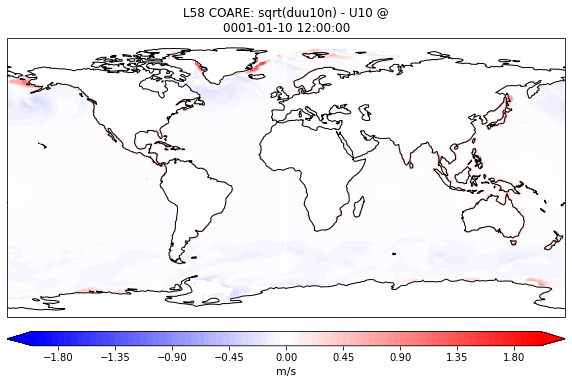

In [16]:
fig,axs = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection':ccrs.PlateCarree()})

timeSel = 60

cplot = axs.contourf(lon, lat, 
            ocnmask*np.squeeze(np.sqrt(duu10n)[timeSel,:,:] - ds['U10'].values[timeSel,:,:]), np.arange(-2,2.05,0.05), cmap='bwr', extend='both')

axs.set_title('L58 COARE: sqrt(duu10n) - U10 @\n'+str(ds.time.values[timeSel]),fontsize=12)
axs.coastlines()

## Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('m/s',fontsize=11)


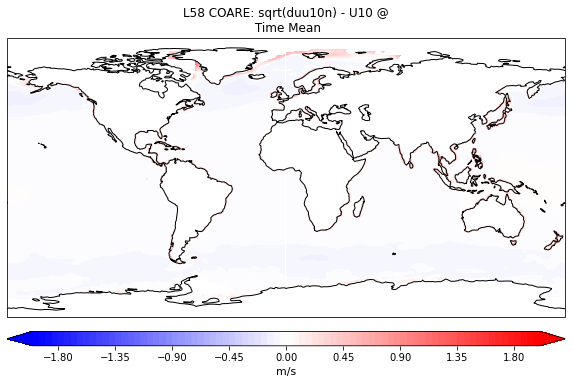

In [18]:
fig,axs = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection':ccrs.PlateCarree()})

cplot = axs.contourf(lon, lat, 
            ocnmask*np.nanmean(np.sqrt(duu10n) - ds['U10'].values, axis=0), np.arange(-2,2.05,0.05), cmap='bwr', extend='both')

axs.set_title('L58 COARE: sqrt(duu10n) - U10 @\n Time Mean',fontsize=12)
axs.coastlines()

## Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('m/s',fontsize=11)




In [17]:
# fig,axs = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection':ccrs.PlateCarree()})

# cplot = axs.contourf(lon, lat, 
#             ocnmask*np.nanmean(tref - ds['TREFHT'].values, axis=0), np.arange(-1,1.05,0.05), cmap='bwr', extend='both')

# axs.set_title('L58 COARE: tref - TREFHT @\n Time Mean',fontsize=12)
# axs.coastlines()

# ## Add colorbar
# ax_position = axs.get_position()
# cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.02])
# cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label('K',fontsize=11)




## Do we see the u10 winds > bottom level winds? 

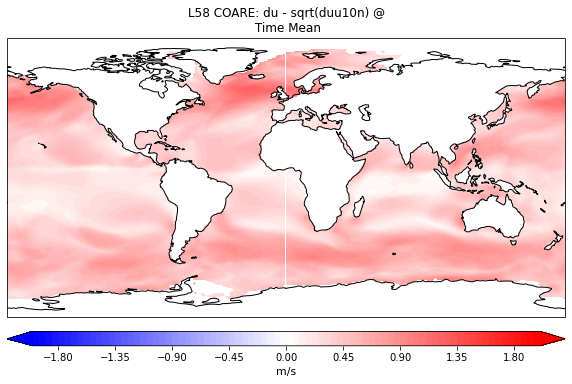

In [19]:
fig,axs = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection':ccrs.PlateCarree()})

cplot = axs.contourf(lon, lat, 
            ocnmask*np.nanmean(du - np.sqrt(duu10n), axis=0), np.arange(-2,2.05,0.05), cmap='bwr', extend='both')

axs.set_title('L58 COARE: du - sqrt(duu10n) @\n Time Mean',fontsize=12)
axs.coastlines()

## Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('m/s',fontsize=11)




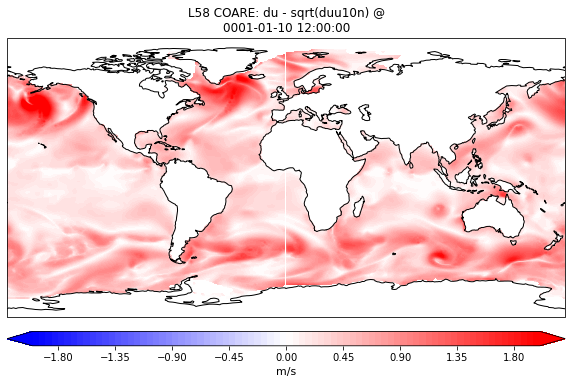

In [20]:
fig,axs = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection':ccrs.PlateCarree()})

timeSel = 60

cplot = axs.contourf(lon, lat, 
            ocnmask*(du[timeSel,:,:] - np.sqrt(duu10n)[timeSel,:,:]), np.arange(-2,2.05,0.05), cmap='bwr', extend='both')

axs.set_title('L58 COARE: du - sqrt(duu10n) @\n'+str(ds.time.values[timeSel]),fontsize=12)
axs.coastlines()

## Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('m/s',fontsize=11)




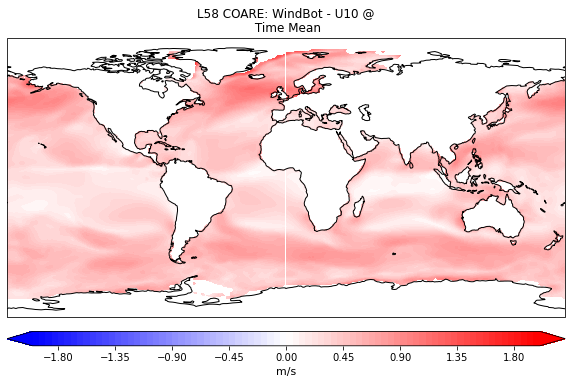

In [21]:
fig,axs = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection':ccrs.PlateCarree()})

cplot = axs.contourf(lon, lat, 
            ocnmask*np.nanmean(np.sqrt(ds['UBOT'].values**2 + ds['VBOT'].values**2) - ds['U10'].values, axis=0), np.arange(-2,2.05,0.05), cmap='bwr', extend='both')

axs.set_title('L58 COARE: WindBot - U10 @\n Time Mean',fontsize=12)
axs.coastlines()

## Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('m/s',fontsize=11)




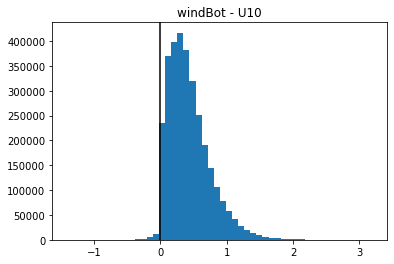

In [28]:
histFileDiffs = ocnmask*np.sqrt(ds['UBOT'].values**2 + ds['VBOT'].values**2) - ds['U10'].values

plt.hist(histFileDiffs.reshape([ntime*nlats*nlons,1]),bins=50)
plt.title('windBot - U10')
plt.axvline(0,color='k')

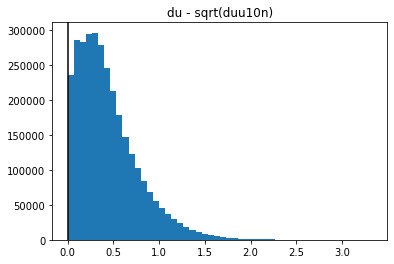

In [23]:
offlineDiffs = ocnmask*(du - np.sqrt(duu10n))

plt.hist(offlineDiffs.reshape([ntime*nlats*nlons,1]),bins=50)
plt.title('du - sqrt(duu10n)')
plt.axvline(0,color='k')


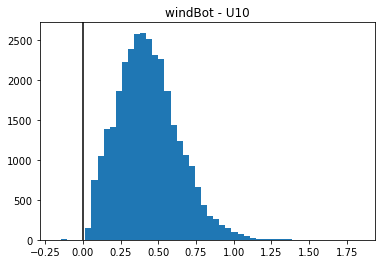

In [29]:
histFileDiffs = ocnmask*np.nanmean(np.sqrt(ds['UBOT'].values**2 + ds['VBOT'].values**2) - ds['U10'].values, axis=0)

plt.hist(histFileDiffs.reshape([nlats*nlons,1]),bins=50)
plt.title('windBot - U10')
plt.axvline(0,color='k')

Timestep with most negative gridcells:  20


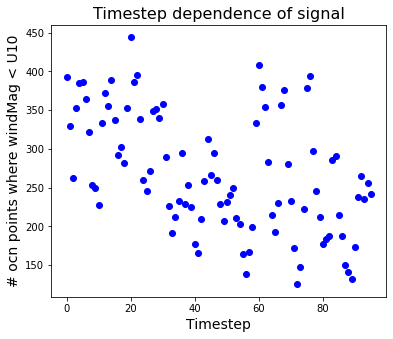

In [30]:
histFileDiffs = np.sqrt(ds['UBOT'].values**2 + ds['VBOT'].values**2) - ds['U10'].values

maxNegSignal = 0
numNegativePoints = 0

fig,axs = plt.subplots(1,1, figsize=(6,5))

for iT in range(ntime):
    iNegative = np.where(ocnmask*histFileDiffs[iT,:,:]<0.0)
    
    numNegativePoints_iT = len(iNegative[0][:])
    
    if numNegativePoints_iT>numNegativePoints:
        numNegativePoints = numNegativePoints_iT
        maxNegSignal = iT 
        
    axs.plot(iT, numNegativePoints_iT, 'bo') 

axs.set_xlabel('Timestep', fontsize=14)
axs.set_ylabel('# ocn points where windMag < U10', fontsize=14)
axs.set_title('Timestep dependence of signal',fontsize=16)
    
print('Timestep with most negative gridcells: ', maxNegSignal)

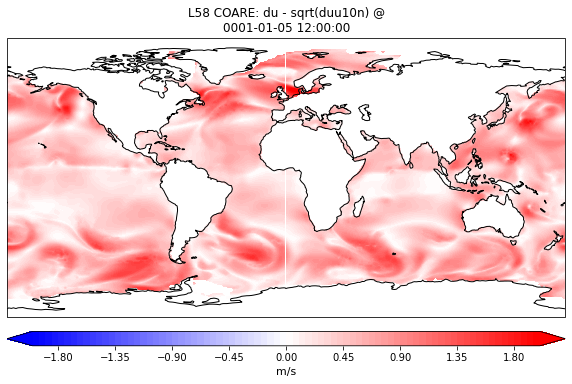

In [31]:
fig,axs = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection':ccrs.PlateCarree()})

timeSel = 20

cplot = axs.contourf(lon, lat, 
            ocnmask*(du[timeSel,:,:] - np.sqrt(duu10n)[timeSel,:,:]), np.arange(-2,2.05,0.05), cmap='bwr', extend='both')

axs.set_title('L58 COARE: du - sqrt(duu10n) @\n'+str(ds.time.values[timeSel]),fontsize=12)
axs.coastlines()

## Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('m/s',fontsize=11)


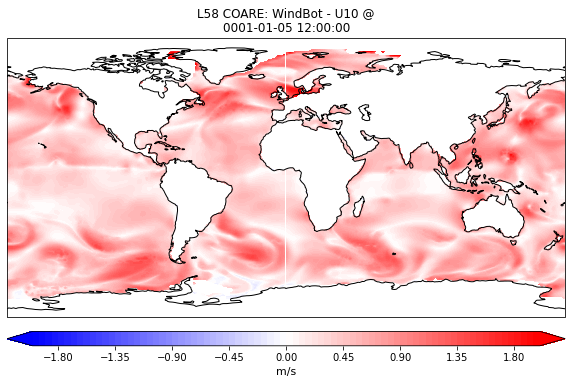

In [32]:
fig,axs = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection':ccrs.PlateCarree()})

timeSel = 20

cplot = axs.contourf(lon, lat, 
            ocnmask*(np.sqrt(ds['UBOT'].values**2+ ds['VBOT'].values**2)[timeSel,:,:] - ds['U10'].values[timeSel,:,:]), np.arange(-2,2.05,0.05), cmap='bwr', extend='both')

axs.set_title('L58 COARE: WindBot - U10 @\n'+str(ds.time.values[timeSel]),fontsize=12)
axs.coastlines()

## Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('m/s',fontsize=11)
